In [5]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

print('GPU name: {}'.format(tf.test.gpu_device_name()))

2.3.0
GPU name: /device:GPU:0


# Sequence modelling 

## Coding tutorials
 #### 1.  The IMDb dataset
 #### 2. Padding and masking sequence data
 #### 3. The `Embedding` layer
 #### 4. The Embedding Projector
 #### 5. Recurrent neural network layers
 #### 6. Stacked RNNs and the `Bidirectional` wrapper

***
<a id="coding_tutorial_1"></a>
## The IMDb Dataset

#### Load the IMDB review sentiment dataset

In [ ]:
# Import imdb

import tensorflow.keras.datasets.imdb as imdb

In [ ]:
# Download and assign the data set using load_data()

(x_train, y_train) ,(x_test, y_test) = imdb.load_data()

#### Inspect the dataset

In [ ]:
# Inspect the type of the data


print(type(x_train))

In [ ]:
# Inspect the shape of the data

print(x_train.shape,y_train.shape,x_test.shape)

In [ ]:
# Display the first dataset element input
# Notice encoding

# Display the first dataset element input
# Notice encoding
x_train[0]


In [ ]:
# Display the first dataset element output
y_train[0]


#### Load dataset with different options

In [ ]:
# Load the dataset with defaults
imdb.load_data(path="imdb.npz",index_from=3) # Top Vocab ambil yang ke 4 , 1 + 3 

# ~/.keras/dataset/

In [ ]:
# Limit the vocabulary to the top 500 words using num_words
imdb.load_data(num_words = 500)


In [ ]:
# Ignore the top 10 most frequent words using skip_top
imdb.load_data(skip_top=10)


In [ ]:
# Limit the sequence lengths to 500 using maxlen
 
imdb.load_data(maxlen=500) # only 500 words per sentiment

In [ ]:
# Use '1' as the character that indicates the start of a sequence
imdb.load_data(start_char=3) # 3 will appear in every dataset.


#### Explore the dataset word index

In [ ]:
# Load the imdb word index using get_word_index()

imdb_word_index = imdb.get_word_index()

In [ ]:
# View the word index as a dictionary,
# accounting for index_from.

index_from = 3
imdb_word_index = {key: value + index_from for key, value in imdb_word_index.items()}
imdb_word_index

In [ ]:
# Retrieve a specific word's index
Inverted_dict_index = {value:key for key,value in imdb_word_index.items()} 
[Inverted_dict_index[key] for key in x_train[0] if key > index_from]


In [ ]:
# View an input sentence

[Inverted_dict_index[key] for key in x_train[7] if key > index_from]


In [ ]:
# Get the sentiment value

y_train[0] , y_train[7]

---
<a id="coding_tutorial_2"></a>
## Padding and Masking Sequence Data

In [ ]:
# Load the imdb data set

import tensorflow.keras.datasets.imdb as imdb
(x_train,y_train) , (x_test,y_test) = imdb.load_data()

#### Preprocess the data with padding

In [ ]:
# Inspect the input data shape

x_train.shape

In [ ]:
# Pad the inputs to the maximum length using maxlen

padded_x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,maxlen = 300, padding="post", truncating="pre")


In [ ]:
# Inspect the output data shape

padded_x_train[0] , x_train[0]

#### Create a Masking layer

In [ ]:
# Import numpy 

import numpy as np

In [ ]:
# Masking expects to see (batch, sequence, features)
# Create a dummy feature dimension using expand_dims
padded_x_train = np.expand_dims(padded_x_train,axis = -1)
padded_x_train

In [ ]:
# Create a Masking layer 

tf_x_train = tf.convert_to_tensor(padded_x_train, dtype = tf.float32)
masking_layer = tf.keras.layers.Masking(mask_value = 0.0)


In [ ]:
# Pass tf_x_train to it
masked_x_train = masking_layer(tf_x_train)


In [ ]:
# Look at the dataset

tf_x_train[0]

In [ ]:
# Look at the ._keras_mask for the dataset

masked_x_train._keras_mask

***
<a id="coding_tutorial_3"></a>
## The Embedding layer

#### Create and apply an `Embedding` layer

In [ ]:
# Create an embedding layer using layers.Embedding
# Specify input_dim, output_dim, input_length
embedding_layer = tf.keras.layers.Embedding(input_dim = 501,output_dim = 64,input_length=32)


In [ ]:
# Inspect an Embedding layer output for a fixed input
# Expects an input of shape (batch, sequence, feature)

sequence_of_indices = tf.constant([[[0],
                                    [1],
                                    [5],
                                    [500]]])
EmbeddingSequences = embedding_layer(sequence_of_indices)
 
sequence_of_indices.shape , EmbeddingSequences.shape

In [ ]:
# Inspect the Embedding layer weights using get_weights()
import numpy as np
np.array(embedding_layer.get_weights()).shape

In [ ]:
# Get the embedding for the 14th index
embedding_layer.get_weights()[0][14,:]


#### Create and apply an `Embedding` layer that uses `mask_zero=True`

In [ ]:
# Create a layer that uses the mask_zero kwarg

masked_embedding_layer = tf.keras.layers.Embedding(input_dim = 501, output_dim = 64, mask_zero=True)

In [ ]:
# Apply this layer to the sequence and see the _keras_mask property

Sampis = masked_embedding_layer(sequence_of_indices)
Sampis._keras_mask

---
<a id="coding_tutorial_4"></a>
## The Embedding Projector

#### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Load and preprocess the IMDb data

In [ ]:
def get_and_pad_imdb_dataset(num_words=10000, maxlen=None, index_from=2):
    import tensorflow.keras.datasets.imdb as imdb
    # Load the reviews
    (x_train, y_train), (x_test, y_test) = imdb.load_data(path='imdb.npz',
                                                          num_words=num_words,
                                                          skip_top=0,
                                                          maxlen=maxlen,
                                                          start_char=1,
                                                          oov_char=2,
                                                          index_from=index_from)


    x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        maxlen=None,
                                                        padding='pre',
                                                        truncating='pre',
                                                        value=0)
    
    x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                           maxlen=None,
                                                           padding='pre',
                                                           truncating='pre',
                                                           value=0)
    return (x_train, y_train), (x_test, y_test)

In [ ]:
# Load the dataset

(x_train,y_train), (x_test,y_test) = get_and_pad_imdb_dataset()

In [ ]:
# A function to get the dataset word index
def get_imdb_word_index(num_words=100000, index_from=2):
    imdb_word_index = tf.keras.datasets.imdb.get_word_index(
                                        path='imdb_word_index.json')
    
    imdb_word_index = {key: value + index_from for key,value in imdb_word_index.items() if value + index_from < num_words}
    
    return imdb_word_index

In [ ]:
# Get the word index

imdb_word_index = get_imdb_word_index()
                                        
print(type(imdb_word_index))

<class 'dict'>


In [ ]:
# Swap the keys and values of the word index
Inverted_Word_index = {value: key for key,value in imdb_word_index.items()}
Inverted_Word_index

{34703: 'fawn',
 52008: 'tsukino',
 52009: 'nunnery',
 16818: 'sonja',
 63953: 'vani',
 1410: 'woods',
 16117: 'spiders',
 2347: 'hanging',
 2291: 'woody',
 52010: 'trawling',
 52011: "hold's",
 11309: 'comically',
 40832: 'localized',
 30570: 'disobeying',
 52012: "'royale",
 40833: "harpo's",
 52013: 'canet',
 19315: 'aileen',
 52014: 'acurately',
 52015: "diplomat's",
 25244: 'rickman',
 6748: 'arranged',
 52016: 'rumbustious',
 52017: 'familiarness',
 52018: "spider'",
 68806: 'hahahah',
 52019: "wood'",
 40835: 'transvestism',
 34704: "hangin'",
 2340: 'bringing',
 40836: 'seamier',
 34705: 'wooded',
 52020: 'bravora',
 16819: 'grueling',
 1638: 'wooden',
 16820: 'wednesday',
 52021: "'prix",
 34706: 'altagracia',
 52022: 'circuitry',
 11587: 'crotch',
 57768: 'busybody',
 52023: "tart'n'tangy",
 14131: 'burgade',
 52025: 'thrace',
 11040: "tom's",
 52027: 'snuggles',
 29116: 'francesco',
 52029: 'complainers',
 52127: 'templarios',
 40837: '272',
 52030: '273',
 52132: 'zaniacs',

In [ ]:
x_train[100]

array([  0,   0,   0, ...,  45,   6, 157], dtype=int32)

In [ ]:
# View the first dataset example sentence

[Inverted_Word_index[Sampis] for Sampis in x_train[100] if Sampis > 2]

['i',
 'am',
 'a',
 'great',
 'fan',
 'of',
 'david',
 'lynch',
 'and',
 'have',
 'everything',
 'that',
 "he's",
 'made',
 'on',
 'dvd',
 'except',
 'for',
 'hotel',
 'room',
 'the',
 '2',
 'hour',
 'twin',
 'peaks',
 'movie',
 'so',
 'when',
 'i',
 'found',
 'out',
 'about',
 'this',
 'i',
 'immediately',
 'grabbed',
 'it',
 'and',
 'and',
 'what',
 'is',
 'this',
 "it's",
 'a',
 'bunch',
 'of',
 'crudely',
 'drawn',
 'black',
 'and',
 'white',
 'cartoons',
 'that',
 'are',
 'loud',
 'and',
 'foul',
 'mouthed',
 'and',
 'unfunny',
 'maybe',
 'i',
 "don't",
 'know',
 "what's",
 'good',
 'but',
 'maybe',
 'this',
 'is',
 'just',
 'a',
 'bunch',
 'of',
 'crap',
 'that',
 'was',
 'foisted',
 'on',
 'the',
 'public',
 'under',
 'the',
 'name',
 'of',
 'david',
 'lynch',
 'to',
 'make',
 'a',
 'few',
 'bucks',
 'too',
 'let',
 'me',
 'make',
 'it',
 'clear',
 'that',
 'i',
 "didn't",
 'care',
 'about',
 'the',
 'foul',
 'language',
 'part',
 'but',
 'had',
 'to',
 'keep',
 'adjusting',
 't

#### Build an Embedding layer into a model

In [ ]:
# Get the maximum token value
input_max_index = max(imdb_word_index.values())


In [ ]:
# Specify an embedding dimension

embedding_dim = 16

In [ ]:
# Build a model using Sequential:
#     1. Embedding layer
#     2. GlobalAveragePooling1D
#     3. Dense

model = tf.keras.Sequential([
                  tf.keras.layers.Embedding(input_dim = input_max_index,output_dim = embedding_dim,mask_zero = False),                             
                  tf.keras.layers.GlobalAveragePooling1D(),
                  tf.keras.layers.Dense(units = 1,activation="sigmoid")

])


In [ ]:
# Functional API refresher: use the Model to build the same model

review_sequence = tf.keras.Input(shape=(None,))
embedding_sequence = tf.keras.layers.Embedding(input_dim=input_max_index+1,output_dim = embedding_dim)(review_sequence)
average_embedding = tf.keras.layers.GlobalAveragePooling1D()(embedding_sequence)
positive_probability = tf.keras.layers.Dense(units = 1, activation ="sigmoid")(average_embedding)
MODEL = tf.keras.Model(inputs = review_sequence, outputs = positive_probability)
MODEL.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 16)          1417392   
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,417,409
Trainable params: 1,417,409
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.summary()

#### Compile, train, and evaluate the model

In [ ]:
# Compile the model with a binary cross-entropy loss
METRICS = [tf.keras.metrics.TruePositives(name="TP"),
           tf.keras.metrics.TrueNegatives(name = "TN"),
           tf.keras.metrics.FalseNegatives(name="FN"),
           tf.keras.metrics.FalsePositives(name="FP"),
           tf.keras.metrics.BinaryAccuracy(name="acc")]

loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=0.001)

MODEL.compile(optimizer=optimizer,metrics=METRICS,loss=loss)

In [ ]:
# Train the model using .fit(), savng its history

history = MODEL.fit(x = x_train,y = y_train,
                    validation_data =(x_test,y_test),
                    validation_steps=20,
                    epochs = 5,batch_size = 32)


Epoch 1/5
782/782 [==============================] - 15s 19ms/step - loss: 0.6190 - TP: 9441.0000 - TN: 9727.0000 - FN: 3059.0000 - FP: 2773.0000 - acc: 0.7667 - val_loss: 0.5968 - val_TP: 240.0000 - val_TN: 252.0000 - val_FN: 70.0000 - val_FP: 78.0000 - val_acc: 0.7688
Epoch 2/5
782/782 [==============================] - 15s 19ms/step - loss: 0.5751 - TP: 9925.0000 - TN: 9907.0000 - FN: 2575.0000 - FP: 2593.0000 - acc: 0.7933 - val_loss: 0.5539 - val_TP: 256.0000 - val_TN: 243.0000 - val_FN: 54.0000 - val_FP: 87.0000 - val_acc: 0.7797
Epoch 3/5
782/782 [==============================] - 15s 19ms/step - loss: 0.5299 - TP: 10338.0000 - TN: 10133.0000 - FN: 2162.0000 - FP: 2367.0000 - acc: 0.8188 - val_loss: 0.5180 - val_TP: 191.0000 - val_TN: 303.0000 - val_FN: 119.0000 - val_FP: 27.0000 - val_acc: 0.7719
Epoch 4/5
782/782 [==============================] - 15s 19ms/step - loss: 0.4884 - TP: 10567.0000 - TN: 10278.0000 - FN: 1933.0000 - FP: 2222.0000 - acc: 0.8338 - val_loss: 0.4780 - v

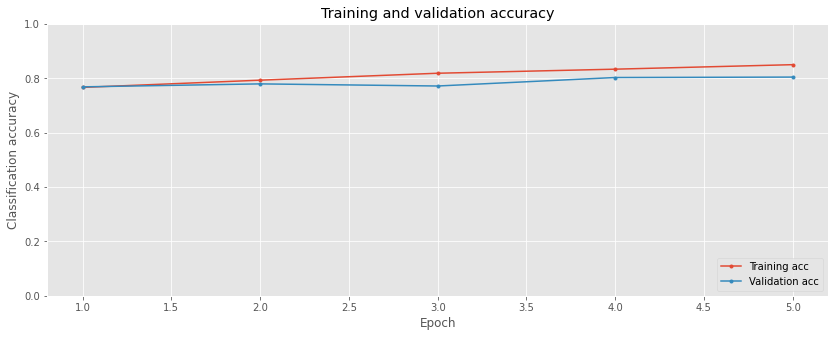

In [ ]:
# Plot the training and validation accuracy

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

history_dict = history.history

acc      = history_dict['acc']
val_acc  = history_dict['val_acc']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))
plt.plot(epochs, acc, marker='.', label='Training acc')
plt.plot(epochs, val_acc, marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1);

#### The TensorFlow embedding projector

The Tensorflow embedding projector can be found [here](https://projector.tensorflow.org/).

In [ ]:
# Retrieve the embedding layer's weights from the trained model

weights = MODEL.layers[1].get_weights()[0]

In [ ]:
# Save the word Embeddings to tsv files
# Two files: 
#     one contains the embedding labels (meta.tsv),
#     one contains the embeddings (vecs.tsv)

import io
from os import path

out_v = io.open(path.join('data', 'vecs.tsv'), 'w', encoding='utf-8')
out_m = io.open(path.join('data', 'meta.tsv'), 'w', encoding='utf-8')

k = 0

for word, token in word_index.items():
    if k != 0:
        out_m.write('\n')
        out_v.write('\n')
    
    out_v.write('\t'.join([str(x) for x in weights[token]]))
    out_m.write(word)
    k += 1
    
out_v.close()
out_m.close()
# beware large collections of embeddings!

FileNotFoundError: ignored

---
<a id="coding_tutorial_5"></a>
## Recurrent neural network layers

#### Initialize and pass an input to a SimpleRNN layer

In [ ]:
# Create a SimpleRNN layer and test it

simpleRnn = tf.keras.layers.SimpleRNN(units = 1)

In [ ]:
# Note that only the final cell output is returned
test = tf.constant([
    [
        [0,4.12],
        [0.32,2.23],
        [21.32,2.1],
    ]])
lol = simpleRnn(test)
lol

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-1.]], dtype=float32)>

#### Load and transform the IMDB review sentiment dataset

In [ ]:
# A function to load and preprocess the IMDB dataset

def get_and_pad_imdb_dataset(num_words=10000, maxlen=None, index_from=2):
    from tensorflow.keras.datasets import imdb

    # Load the reviews
    (x_train, y_train), (x_test, y_test) = imdb.load_data(path='imdb.npz',
                                                          num_words=num_words,
                                                          skip_top=0,
                                                          maxlen=maxlen,
                                                          start_char=1,
                                                          oov_char=2,
                                                          index_from=index_from)
    x_train=x_train[:1000]
    x_test = x_test[:1000]
    y_train=y_train[:1000]
    y_test =y_test[:1000]
    x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        maxlen=None,
                                                        padding='pre',
                                                        truncating='pre',
                                                        value=0)
    
    x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                           maxlen=None,
                                                           padding='pre',
                                                           truncating='pre',
                                                           value=0)
    return (x_train, y_train), (x_test, y_test)

In [ ]:
# Load the dataset
(x_train,y_train),(x_test,y_test) = get_and_pad_imdb_dataset()


17465344/17464789 [==============================] - 0s 0us/step


In [ ]:
x_train.shape

(1000, 1038)

In [ ]:
# A function to get the dataset word index

def get_imdb_word_index(num_words=10000, index_from=2):
    imdb_word_index = tf.keras.datasets.imdb.get_word_index(
                                        path='imdb_word_index.json')
    imdb_word_index = {key: value + index_from for
                       key, value in imdb_word_index.items() if value <= num_words-index_from}
    return imdb_word_index

In [ ]:
# Get the word index using get_imdb_word_index()

imdb_word_index = get_imdb_word_index()

1646592/1641221 [==============================] - 0s 0us/step


#### Create a recurrent neural network model

In [ ]:
# Get the maximum index value
maxindx = max(imdb_word_index.values())


In [ ]:
# Using Sequential, build the model:
# 1. Embedding.
# 2. LSTM.
# 3. Dense.
InputLayer = tf.keras.Input((None, ))
Layers = tf.keras.layers.Embedding(input_dim = maxindx,output_dim=16,mask_zero=True)(InputLayer)
Layers = tf.keras.layers.LSTM(units = 16,activation="tanh")(Layers)
Layers = tf.keras.layers.Dense(units = 1,activation="sigmoid")(Layers)

MODEL = tf.keras.Model(inputs = InputLayer , outputs = Layers)
MODEL.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 162,129
Trainable params: 162,129
Non-trainable params: 0
_________________________________________________________________


#### Compile and fit the model

In [ ]:
# Compile the model with binary cross-entropy loss

# Compile the model with binary cross-entropy loss
loss = tf.keras.losses.BinaryCrossentropy()
METRICS = [tf.keras.metrics.TrueNegatives(name="TN"),
          tf.keras.metrics.TruePositives(name="TP"),
          tf.keras.metrics.FalseNegatives(name="FN"),
          tf.keras.metrics.FalsePositives(name="FP"),
          tf.keras.metrics.BinaryAccuracy(name="acc")]
optimizer = tf.keras.optimizers.Adam(lr=0.001)

MODEL.compile(loss= loss,metrics= METRICS, optimizer=optimizer)


In [ ]:
# Fit the model and save its training history
with tf.device(tf.test.gpu_device_name()):
  history = MODEL.fit(x = x_train,y=y_train,
          validation_data = (x_test,y_test),
          epochs = 5,batch_size = 32)

Epoch 1/5
32/32 [==============================] - 72s 2s/step - loss: 0.1671 - TN: 493.0000 - TP: 476.0000 - FN: 18.0000 - FP: 13.0000 - acc: 0.9690 - val_loss: 0.4596 - val_TN: 388.0000 - val_TP: 397.0000 - val_FN: 77.0000 - val_FP: 138.0000 - val_acc: 0.7850
Epoch 2/5
32/32 [==============================] - 71s 2s/step - loss: 0.1071 - TN: 497.0000 - TP: 492.0000 - FN: 2.0000 - FP: 9.0000 - acc: 0.9890 - val_loss: 0.4648 - val_TN: 380.0000 - val_TP: 401.0000 - val_FN: 73.0000 - val_FP: 146.0000 - val_acc: 0.7810
Epoch 3/5
32/32 [==============================] - 71s 2s/step - loss: 0.0652 - TN: 504.0000 - TP: 491.0000 - FN: 3.0000 - FP: 2.0000 - acc: 0.9950 - val_loss: 0.4995 - val_TN: 460.0000 - val_TP: 341.0000 - val_FN: 133.0000 - val_FP: 66.0000 - val_acc: 0.8010
Epoch 4/5
32/32 [==============================] - 70s 2s/step - loss: 0.0397 - TN: 506.0000 - TP: 492.0000 - FN: 2.0000 - FP: 0.0000e+00 - acc: 0.9980 - val_loss: 0.5694 - val_TN: 413.0000 - val_TP: 380.0000 - val_FN:

#### Plot learning curves

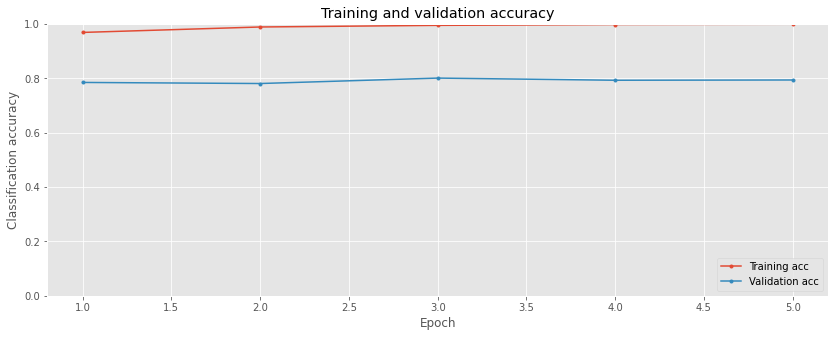

In [ ]:
# Plot the training and validation accuracy

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

history_dict = history.history

acc      = history_dict['acc']
val_acc  = history_dict['val_acc']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))
plt.plot(epochs, acc, marker='.', label='Training acc')
plt.plot(epochs, val_acc, marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1);

#### Make predictions with the model

In [ ]:
# View the first test data example sentence
# (invert the word index)
inv_imdb_index = {value:key for key,value in imdb_word_index.items()}
[inv_imdb_index[index] for index in x_test[1] if index > 2]

['this',
 'film',
 'requires',
 'a',
 'lot',
 'of',
 'patience',
 'because',
 'it',
 'focuses',
 'on',
 'mood',
 'and',
 'character',
 'development',
 'the',
 'plot',
 'is',
 'very',
 'simple',
 'and',
 'many',
 'of',
 'the',
 'scenes',
 'take',
 'place',
 'on',
 'the',
 'same',
 'set',
 'in',
 'frances',
 'the',
 'sandy',
 'dennis',
 'character',
 'apartment',
 'but',
 'the',
 'film',
 'builds',
 'to',
 'a',
 'disturbing',
 'climax',
 'br',
 'br',
 'the',
 'characters',
 'create',
 'an',
 'atmosphere',
 'with',
 'sexual',
 'tension',
 'and',
 'psychological',
 "it's",
 'very',
 'interesting',
 'that',
 'robert',
 'altman',
 'directed',
 'this',
 'considering',
 'the',
 'style',
 'and',
 'structure',
 'of',
 'his',
 'other',
 'films',
 'still',
 'the',
 'trademark',
 'altman',
 'audio',
 'style',
 'is',
 'evident',
 'here',
 'and',
 'there',
 'i',
 'think',
 'what',
 'really',
 'makes',
 'this',
 'film',
 'work',
 'is',
 'the',
 'brilliant',
 'performance',
 'by',
 'sandy',
 'dennis',


In [ ]:
x_test[1]

array([   0,    0,    0, ...,  124,    3, 3076], dtype=int32)

In [ ]:
# Get the model prediction using model.predict()

Sampis = MODEL.predict(x_test[None,0,:])
Sampis

array([[0.08086041]], dtype=float32)

In [ ]:
# Get the corresponding label
y_test[1] == Sampis

array([[False]])

---
<a id="coding_tutorial_6"></a>
## Stacked RNNs and the Bidirectional wrapper

#### Load and transform the IMDb review sentiment dataset

In [24]:
# A function to load and preprocess the IMDB dataset

def get_and_pad_imdb_dataset(num_words=10000, maxlen=None, index_from=2):
    from tensorflow.keras.datasets import imdb

    # Load the reviews
    (x_train, y_train), (x_test, y_test) = imdb.load_data(path='imdb.npz',
                                                          num_words=num_words,
                                                          skip_top=0,
                                                          maxlen=maxlen,
                                                          start_char=1,
                                                          oov_char=2,
                                                          index_from=index_from)
    x_train=x_train[:1000]
    x_test = x_test[:1000]
    y_train=y_train[:1000]
    y_test =y_test[:1000]
    x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        maxlen=None,
                                                        padding='pre',
                                                        truncating='pre',
                                                        value=0)
    
    x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                           maxlen=None,
                                                           padding='pre',
                                                           truncating='pre',
                                                           value=0)
    return (x_train, y_train), (x_test, y_test)

In [25]:
# Load the dataset

(x_train,y_train), (x_test, y_test) = get_and_pad_imdb_dataset()

In [8]:
# A function to get the dataset word index

def get_imdb_word_index(num_words=10000, index_from=2):
    imdb_word_index = tf.keras.datasets.imdb.get_word_index(
                                        path='imdb_word_index.json')
    imdb_word_index = {key: value + index_from for
                       key, value in imdb_word_index.items() if value <= num_words-index_from}
    return imdb_word_index

In [9]:
# Get the word index using get_imdb_word_index()

imdb_word_index = get_imdb_word_index()


1646592/1641221 [==============================] - 0s 0us/step


#### Build stacked and bidirectional recurrent models

In [10]:
# Get the maximum index value and specify an embedding dimension

max_input = max(imdb_word_index.values())
embedding_dim = 32

In [12]:
# Using Sequential, build a stacked LSTM model via return_sequences=True

Inputs=tf.keras.Input(shape=(None, ))
Layers = tf.keras.layers.Embedding(input_dim=max_input, output_dim=embedding_dim,mask_zero=True)(Inputs)
Layers = tf.keras.layers.LSTM(units=32,return_sequences=True)(Layers)
Layers = tf.keras.layers.LSTM(units=16,return_sequences=False)(Layers)
Layers = tf.keras.layers.Dense(units=1,activation="sigmoid")(Layers)

MODEL = tf.keras.Model(inputs=Inputs,outputs=Layers)
MODEL.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 331,473
Trainable params: 331,473
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Using Sequential, build a bidirectional RNN with merge_mode='sum'

Inputs=tf.keras.Input(shape=(None, ))
Layers = tf.keras.layers.Embedding(input_dim=max_input, output_dim=embedding_dim,mask_zero=True)(Inputs)
Layers = tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(units=32,return_sequences=True),merge_mode='sum' )(Layers)
Layers = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=16,return_sequences=False),
                                       backward_layer = tf.keras.layers.GRU(units=16,go_backwards=True),merge_mode="sum")(Layers)
Layers = tf.keras.layers.Dense(units=1,activation="sigmoid")(Layers)

MODEL = tf.keras.Model(inputs=Inputs,outputs=Layers)
MODEL.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 32)          16640     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 16)                5536      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 342,193
Trainable params: 342,193
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Create a model featuring both stacked recurrent layers and a bidirectional layer

Inputs=tf.keras.Input(shape=(None, ))
Layers = tf.keras.layers.Masking(mask_value=0)(Inputs)
Layers = tf.keras.layers.Embedding(input_dim=max_input, output_dim=embedding_dim,mask_zero=True)(Layers)
Layers = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=16,return_sequences=True),
                                       backward_layer = tf.keras.layers.GRU(units=16,go_backwards=True,return_sequences=True),merge_mode="sum")(Layers)
Layers = tf.keras.layers.GRU(units=8,return_sequences=False)(Layers)                                 
Layers = tf.keras.layers.Dense(units=1,activation="sigmoid")(Layers)

MODEL = tf.keras.Model(inputs=Inputs,outputs=Layers)
MODEL.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
masking_1 (Masking)          (None, None)              0         
_________________________________________________________________
embedding_9 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, None, 16)          5536      
_________________________________________________________________
gru_9 (GRU)                  (None, 8)                 624       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 326,169
Trainable params: 326,169
Non-trainable params: 0
________________________________________________

#### Compile and fit the model

In [30]:
# Compile the model

loss = tf.keras.losses.BinaryCrossentropy()
METRICS=[tf.keras.metrics.TrueNegatives(name="TN"),
         tf.keras.metrics.TruePositives(name="TP"),
         tf.keras.metrics.FalseNegatives(name="FN"),
         tf.keras.metrics.FalsePositives(name="FP"),
         tf.keras.metrics.BinaryAccuracy(name="accuracy")]

Optimizer = tf.keras.optimizers.Adam(lr=0.001)
MODEL.compile(loss=loss,metrics=METRICS,optimizer=Optimizer)

In [31]:
# Train the model, saving its history

history = MODEL.fit(x = x_train,y=y_train,
          validation_data = (x_test,y_test),
          batch_size = 32,
          epochs = 5)

Epoch 1/5
32/32 [==============================] - 227s 7s/step - loss: 0.6924 - TN: 235.0000 - TP: 286.0000 - FN: 208.0000 - FP: 271.0000 - accuracy: 0.5210 - val_loss: 0.6892 - val_TN: 458.0000 - val_TP: 133.0000 - val_FN: 341.0000 - val_FP: 68.0000 - val_accuracy: 0.5910
Epoch 2/5
32/32 [==============================] - 225s 7s/step - loss: 0.6690 - TN: 489.0000 - TP: 190.0000 - FN: 304.0000 - FP: 17.0000 - accuracy: 0.6790 - val_loss: 0.6619 - val_TN: 324.0000 - val_TP: 341.0000 - val_FN: 133.0000 - val_FP: 202.0000 - val_accuracy: 0.6650
Epoch 3/5
32/32 [==============================] - 224s 7s/step - loss: 0.4518 - TN: 441.0000 - TP: 427.0000 - FN: 67.0000 - FP: 65.0000 - accuracy: 0.8680 - val_loss: 0.4648 - val_TN: 371.0000 - val_TP: 403.0000 - val_FN: 71.0000 - val_FP: 155.0000 - val_accuracy: 0.7740
Epoch 4/5
32/32 [==============================] - 224s 7s/step - loss: 0.1490 - TN: 484.0000 - TP: 481.0000 - FN: 13.0000 - FP: 22.0000 - accuracy: 0.9650 - val_loss: 0.4985 - 

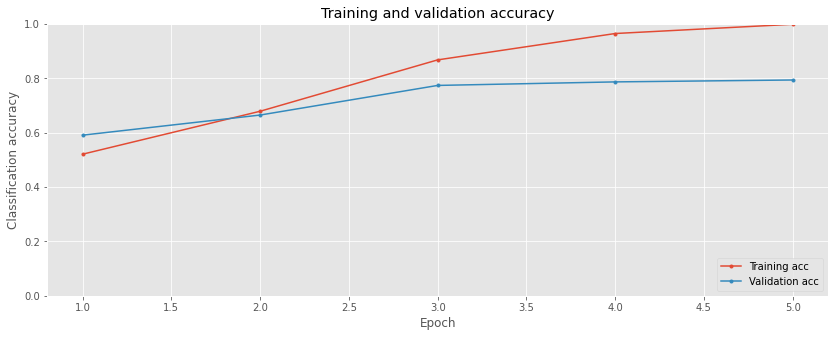

In [32]:
# Plot the training and validation accuracy

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

history_dict = history.history

acc      = history_dict['accuracy']
val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))
plt.plot(epochs, acc, marker='.', label='Training acc')
plt.plot(epochs, val_acc, marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1);